In [ ]:
import pandas as pd
import numpy as np
import os
import tqdm

In [ ]:
def load_and_conact_shots_from_log(fp: str, df1):

    # example path to a log
    df = pd.read_csv(fp, delimiter=";")

    # mask out everything but shot attempts
    mask = (df['action_name'].str.contains('-', regex=False) | df['action_name'].str.contains('+', regex=False)) & \
    ~ (df['action_name'].str.contains('1', regex=False))
    shots = df[mask]

    # feature selection
    player_id = shots.player_id
    team_id = shots.team_id
    opponent_id = shots.opponent_id
    playtype = shots.playtype
    shot_type = shots.shot_type
    pos_x = shots.pos_x
    pos_y = shots.pos_y
    half = shots.half
    attempt_type = np.array([])
    shot_outcome = np.array([])

    # shot attempt type: i.e. (2, 3)
    # 0: make, 1: miss
    for action in shots.action_name.values:
        point_attempt = action[0]
        outcome = 0 if "+" in action else 1
        attempt_type = np.append(attempt_type, point_attempt)
        shot_outcome = np.append(shot_outcome, outcome)

    # features table
    features = pd.DataFrame({'shot_outcome': shot_outcome,
                            'attempt_type': attempt_type,
                            'player_id': player_id,
                            'team_id': team_id,
                            'opponent_id': opponent_id,
                            'playtype': playtype, 
                            'shot_type': shot_type,
                            'pos_x': pos_x,
                            'pos_y': pos_y,
                            'half': half,
                            })
    
    return pd.concat([features, df1], axis=0)

def generate_features():
    """
    Load and concatinate all shots from a logs dir.
    """

    logs_dir = r"logs\15-16"
    logs = os.listdir(logs_dir)
    df_temp = None
    for log in tqdm.tqdm(logs):
        lp = os.path.join(logs_dir, log)
        df_temp = load_and_conact_shots_from_log(lp, df_temp)
    return df_temp

features = generate_features()

In [ ]:
features.dropna(subset=['playtype', 'shot_type', 'pos_x', 'pos_y'], inplace=True)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load your data (assuming it's loaded into a DataFrame 'df')

# Separate features and target variable
X = features.drop('shot_outcome', axis=1)
y = features['shot_outcome']

# Handling categorical columns with OneHotEncoding
categorical_features = ['playtype', 'shot_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Handling numerical columns with StandardScaler
numeric_features = ['pos_x', 'pos_y']  # add more numerical features if available
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Combining preprocessing for both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying the transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_train, X_test

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Building the model
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))  # input layer requires input_dim param
model.add(Dense(8, activation='relu'))  # hidden layer
model.add(Dense(4, activation='relu'))  # hidden layer
model.add(Dense(2, activation='relu'))  # hidden layer
model.add(Dense(1, activation='sigmoid'))  # output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [143]:
# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
670/670 [==============================] - 1s 2ms/step - loss: 0.6705 - accuracy: 0.5947 - val_loss: 0.6615 - val_accuracy: 0.6271
Epoch 2/100
670/670 [==============================] - 1s 1ms/step - loss: 0.6592 - accuracy: 0.6251 - val_loss: 0.6555 - val_accuracy: 0.6291
Epoch 3/100
670/670 [==============================] - 1s 1ms/step - loss: 0.6541 - accuracy: 0.6259 - val_loss: 0.6508 - val_accuracy: 0.6299
Epoch 4/100
670/670 [==============================] - 1s 1ms/step - loss: 0.6510 - accuracy: 0.6259 - val_loss: 0.6489 - val_accuracy: 0.6288
Epoch 5/100
670/670 [==============================] - 1s 1ms/step - loss: 0.6488 - accuracy: 0.6261 - val_loss: 0.6470 - val_accuracy: 0.6288
Epoch 6/100
670/670 [==============================] - 1s 1ms/step - loss: 0.6473 - accuracy: 0.6256 - val_loss: 0.6451 - val_accuracy: 0.6301
Epoch 7/100
670/670 [==============================] - 1s 1ms/step - loss: 0.6462 - accuracy: 0.6268 - val_loss: 0.6442 - val_accuracy: 0.6302

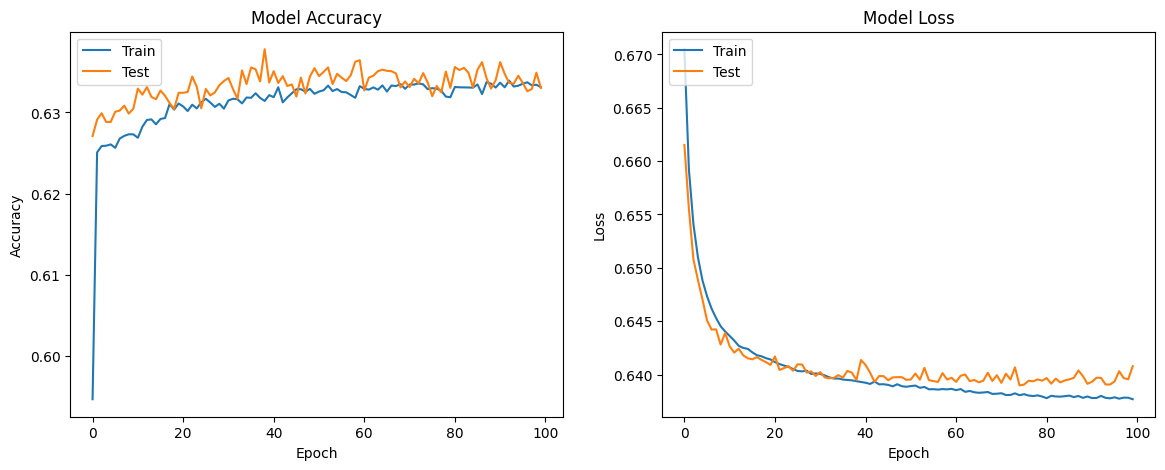

In [144]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [147]:
sum(y.values) / len(y.values)

0.5637997983795692